In [6]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import os

In [2]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

MODEL_DIR = Path.cwd()

In [29]:
df = pd.read_csv(DATA_DIR / "dataset_sat_images.csv", parse_dates=["date"])
df.head()

uid   latitude  longitude       date  split   region  severity    density  \
0  aabm  39.080319 -86.430867 2018-05-14  train  midwest         1      585.0   
1  aacd  35.875083 -78.878434 2020-11-19  train    south         1      290.0   
2  aaee  35.487000 -79.062133 2016-08-24  train    south         1     1614.0   
3  aaff  38.049471 -99.827001 2019-07-23  train  midwest         3   111825.0   
4  aafl  39.474744 -86.898353 2021-08-23  train  midwest         4  2017313.0   

  image_src  
0  sentinel  
1  sentinel  
2  no_image  
3  sentinel  
4  sentinel

In [4]:
# remove id's where no sat images could be collected
print("Initial entries in dataset: ", len(df))
errored_ids = ['einx', 'gygq', 'ifwc', 'jdvp', 'qpeh', 'tgiq', 'wrqa']
for id in errored_ids:
    df.drop(df.loc[df['uid']==id].index, inplace=True)
print("Remaining entries in dataset: ", len(df))
image_count = len(df)

Initial entries in dataset:  17060
Remaining entries in dataset:  17053


In [5]:
# add filepaths to dataframe
def get_path(id):
   return str(DATA_DIR/'sat_images/image_arrays_8_layer_2/') + f"/{id}.npy"

df['path'] = df["uid"].apply(get_path)

pd.set_option('display.max_colwidth', None)
df.head(5)

uid   latitude  longitude        date  split   region  severity  \
0  aabm  39.080319 -86.430867  2018-05-14  train  midwest         1   
1  aacd  35.875083 -78.878434  2020-11-19  train    south         1   
2  aaee  35.487000 -79.062133  2016-08-24  train    south         1   
3  aaff  38.049471 -99.827001  2019-07-23  train  midwest         3   
4  aafl  39.474744 -86.898353  2021-08-23  train  midwest         4   

     density image_src  \
0      585.0  sentinel   
1      290.0  sentinel   
2     1614.0  no_image   
3   111825.0  sentinel   
4  2017313.0  sentinel   

                                                                                       path  
0  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aabm.npy  
1  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aacd.npy  
2  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaee.npy  
3  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaff.npy  
4  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aafl.npy

In [6]:
example_row = df[df.uid == "aabm"].iloc[0]
example_row

uid                                                                                              aabm
latitude                                                                                    39.080319
longitude                                                                                  -86.430867
date                                                                                       2018-05-14
split                                                                                           train
region                                                                                        midwest
severity                                                                                            1
density                                                                                         585.0
image_src                                                                                    sentinel
path         /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays

## Extract features from satellite image files

In [7]:
def get_image_features(image_layers):
    # count water pixels
    num_water_pxl = (image_layers[4] > 0.0).sum()
    # calculate mean color values from masked (water-only) layers
    mean_r  = image_layers[4].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_g  = image_layers[5].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_b  = image_layers[6].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_ir = image_layers[7].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    
    # calculate HSV transformed image from water-only layers
    rgb = np.array([image_layers[4],image_layers[5],image_layers[6]])
    hsv = np.transpose(cv2.cvtColor(np.transpose((rgb), axes=[1, 2, 0]), cv2.COLOR_RGB2HSV), axes=[2, 0, 1])

    # calculate mean values for hue, saturation and value (hue is scaled from 360° into 0...1 range)
    mean_h  = hsv[0].sum()/(num_water_pxl*360) if (num_water_pxl > 0) else 0.0
    mean_s  = hsv[1].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_v  = hsv[2].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0

    features = {'lake_size': num_water_pxl,
                'mean_r': mean_r, 
                'mean_g': mean_g, 
                'mean_b': mean_b, 
                'mean_ir': mean_ir, 
                'mean_h': mean_h,
                'mean_s': mean_s,
                'mean_v': mean_v}

    return features

In [8]:
image_layers = np.load(example_row.path)
features = get_image_features(image_layers)
features

{'lake_size': 2578,
 'mean_r': 0.467581288032147,
 'mean_g': 0.6074859406062112,
 'mean_b': 0.5362475907922808,
 'mean_ir': 0.42440888232459756,
 'mean_h': 0.41378191400525816,
 'mean_s': 0.2341533983465865,
 'mean_v': 0.6078412608641631}

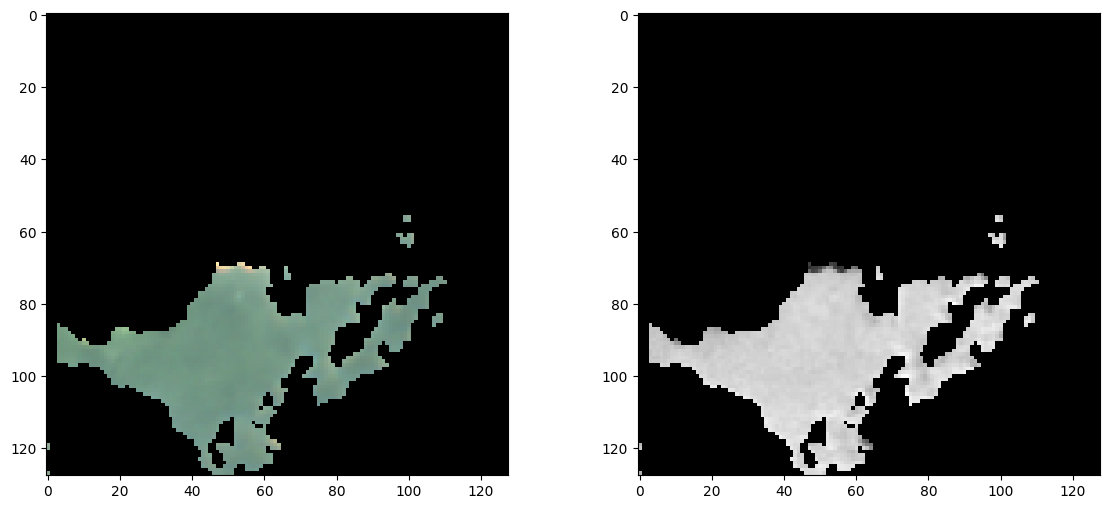

In [9]:
# show loaded image and hsv conversion
rgb = np.array([image_layers[4],image_layers[5],image_layers[6]])
hsv = np.transpose(cv2.cvtColor(np.transpose((rgb), axes=[1, 2, 0]), cv2.COLOR_RGB2HSV), axes=[2, 0, 1])

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((rgb), axes=[1, 2, 0]))
plt.subplot(122)
# plot hsv image (will be false colors)
#plt.imshow(np.transpose((hsv), axes=[1, 2, 0]));
# or plot only hue layer
plt.imshow(hsv[0], cmap='gray');

### Ectract features for all images

In [10]:
# use only part of the dataset where images were found
image_df = df[df['image_src'] != 'no_image']
image_df

uid   latitude   longitude        date  split   region  severity  \
0      aabm  39.080319  -86.430867  2018-05-14  train  midwest         1   
1      aacd  35.875083  -78.878434  2020-11-19  train    south         1   
3      aaff  38.049471  -99.827001  2019-07-23  train  midwest         3   
4      aafl  39.474744  -86.898353  2021-08-23  train  midwest         4   
8      aaia  35.980000  -78.791686  2018-06-27  train    south         1   
...     ...        ...         ...         ...    ...      ...       ...   
17052  zzqy  37.928600 -121.561000  2018-05-15  train     west         4   
17054  zzry  38.256057  -86.776403  2021-07-19  train  midwest         2   
17055  zzsv  38.707825  -75.080867  2018-06-27  train    south         3   
17057  zzwo  39.792190  -99.971050  2017-06-19  train  midwest         2   
17059  zzyb  35.742000  -79.238600  2016-11-21  train    south         1   

         density image_src  \
0          585.0  sentinel   
1          290.0  sentinel   
3       111825.0  sentinel   
4      2017313.0  sentinel   
8        16943.0  sentinel   
...          ...       ...   
17052  5548841.0  sentinel   
17054    63056.0  sentinel   
17055   113125.0  sentinel   
17057    48510.0  sentinel   
17059     9682.0  sentinel   

                                                                                           path  
0      /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aabm.npy  
1      /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aacd.npy  
3      /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaff.npy  
4      /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aafl.npy  
8      /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaia.npy  
...                                                                                         ...  
17052  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzqy.npy  
17054  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzry.npy  
17055  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzsv.npy  
17057  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzwo.npy  
17059  /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzyb.npy  

[6176 rows x 10 columns]

In [11]:
# extract features from all images
for row in tqdm(image_df.itertuples(), total=len(image_df)):
    # load image file
    image_layers = np.load(row.path)

    # extract features
    features = get_image_features(image_layers)

    # add features to dataframe
    df.loc[df['uid'] == row.uid, ['lake_size']] = features['lake_size']
    df.loc[df['uid'] == row.uid, ['mean_r']] = features['mean_r']
    df.loc[df['uid'] == row.uid, ['mean_g']] = features['mean_g']
    df.loc[df['uid'] == row.uid, ['mean_b']] = features['mean_b']
    df.loc[df['uid'] == row.uid, ['mean_ir']] = features['mean_ir']
    df.loc[df['uid'] == row.uid, ['mean_h']] = features['mean_h']
    df.loc[df['uid'] == row.uid, ['mean_s']] = features['mean_s']
    df.loc[df['uid'] == row.uid, ['mean_v']] = features['mean_v']


100%|██████████| 6176/6176 [00:49<00:00, 124.16it/s]


In [12]:
df = df.drop('path', axis=1)

In [13]:
df.head(10)

uid   latitude  longitude        date  split   region  severity  \
0  aabm  39.080319 -86.430867  2018-05-14  train  midwest         1   
1  aacd  35.875083 -78.878434  2020-11-19  train    south         1   
2  aaee  35.487000 -79.062133  2016-08-24  train    south         1   
3  aaff  38.049471 -99.827001  2019-07-23  train  midwest         3   
4  aafl  39.474744 -86.898353  2021-08-23  train  midwest         4   
5  aafp  35.647742 -79.271782  2017-11-15  train    south         1   
6  aagm  35.906885 -79.132962  2020-06-10  train    south         1   
7  aahy  35.726522 -79.125458  2014-08-12  train    south         1   
8  aaia  35.980000 -78.791686  2018-06-27  train    south         1   
9  aaie  35.861325 -78.768321  2013-11-06  train    south         2   

     density image_src  lake_size    mean_r    mean_g    mean_b   mean_ir  \
0      585.0  sentinel     2578.0  0.467581  0.607486  0.536248  0.424409   
1      290.0  sentinel      176.0  0.112471  0.111118  0.057916  0.059888   
2     1614.0  no_image        NaN       NaN       NaN       NaN       NaN   
3   111825.0  sentinel     1495.0  0.065787  0.085121  0.044582  0.020998   
4  2017313.0  sentinel     8045.0  0.166186  0.276183  0.181284  0.127355   
5     1594.0  no_image        NaN       NaN       NaN       NaN       NaN   
6     3873.0  no_image        NaN       NaN       NaN       NaN       NaN   
7     6100.0  no_image        NaN       NaN       NaN       NaN       NaN   
8    16943.0  sentinel        3.0  0.208500  0.298184  0.261890  0.232462   
9    22822.0  no_image        NaN       NaN       NaN       NaN       NaN   

     mean_h    mean_s    mean_v  
0  0.413782  0.234153  0.607841  
1  0.163396  0.503357  0.115065  
2       NaN       NaN       NaN  
3  0.245394  0.480389  0.085137  
4  0.356467  0.412104  0.276187  
5       NaN       NaN       NaN  
6       NaN       NaN       NaN  
7       NaN       NaN       NaN  
8  0.432910  0.302307  0.298184  
9       NaN       NaN       NaN

In [14]:
# save image features to csv file
#df.to_csv(DATA_DIR / "dataset_img_features.csv", index=False)

## Data Cleaning

In [35]:
# read dataset from csv file
df = pd.read_csv(DATA_DIR / "dataset_img_features.csv", parse_dates=["date"])
# add day of the year as additional feature
df['dayofyear'] = df['date'].dt.dayofyear
df.head()

uid   latitude  longitude       date  split   region  severity    density  \
0  aabm  39.080319 -86.430867 2018-05-14  train  midwest         1      585.0   
1  aacd  35.875083 -78.878434 2020-11-19  train    south         1      290.0   
2  aaee  35.487000 -79.062133 2016-08-24  train    south         1     1614.0   
3  aaff  38.049471 -99.827001 2019-07-23  train  midwest         3   111825.0   
4  aafl  39.474744 -86.898353 2021-08-23  train  midwest         4  2017313.0   

  image_src  lake_size    mean_r    mean_g    mean_b   mean_ir    mean_h  \
0  sentinel     2578.0  0.467581  0.607486  0.536248  0.424409  0.413782   
1  sentinel      176.0  0.112471  0.111118  0.057916  0.059888  0.163396   
2  no_image        NaN       NaN       NaN       NaN       NaN       NaN   
3  sentinel     1495.0  0.065787  0.085121  0.044582  0.020998  0.245394   
4  sentinel     8045.0  0.166186  0.276183  0.181284  0.127355  0.356467   

     mean_s    mean_v  dayofyear  
0  0.234153  0.607841        134  
1  0.503357  0.115065        324  
2       NaN       NaN        237  
3  0.480389  0.085137        204  
4  0.412104  0.276187        235

In [36]:
# only 6176 datapoints contain image features (there are no images for the others)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17053 entries, 0 to 17052
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   uid        17053 non-null  object        
 1   latitude   17053 non-null  float64       
 2   longitude  17053 non-null  float64       
 3   date       17053 non-null  datetime64[ns]
 4   split      17053 non-null  object        
 5   region     17053 non-null  object        
 6   severity   17053 non-null  int64         
 7   density    17053 non-null  float64       
 8   image_src  17053 non-null  object        
 9   lake_size  6176 non-null   float64       
 10  mean_r     6176 non-null   float64       
 11  mean_g     6176 non-null   float64       
 12  mean_b     6176 non-null   float64       
 13  mean_ir    6176 non-null   float64       
 14  mean_h     6176 non-null   float64       
 15  mean_s     6176 non-null   float64       
 16  mean_v     6176 non-null   float64      

## Modeling

In [37]:
# create subset with only datapoints that contain image information
subset = df[df['image_src'] != 'no_image'].copy()

In [39]:
# all of the features are numerical
features = ['latitude', 'longitude', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
            'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'dayofyear']
subset[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6176 entries, 0 to 17052
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   6176 non-null   float64
 1   longitude  6176 non-null   float64
 2   lake_size  6176 non-null   float64
 3   mean_r     6176 non-null   float64
 4   mean_g     6176 non-null   float64
 5   mean_b     6176 non-null   float64
 6   mean_ir    6176 non-null   float64
 7   mean_h     6176 non-null   float64
 8   mean_s     6176 non-null   float64
 9   mean_v     6176 non-null   float64
 10  dayofyear  6176 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 579.0 KB


In [ ]:
# train test split

In [ ]:
# normalize features (esp. 'latitude', 'longitude', 'lake_size', 'dayofyear')

In [ ]:
# select features

In [15]:
# Clear any logs from previous runs
#!rm -rf ./logs/

In [ ]:
# # region based RMSE score
# region_scores = []
# for region in val_set.region.unique():
#     sub = val_set[val_set.region == region]
#     region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
#     print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
#     region_scores.append(region_rmse)

# overall_rmse = np.mean(region_scores)
# print(f"Final score: {overall_rmse}")

In [ ]:
# # score not based on regions
# mean_squared_error(y_val, val_preds, squared=False)

In [92]:
temp = pd.read_csv('../data/temperature.csv', parse_dates=['date'])
temp.head()

uid   latitude   longitude       date  split  \
0  aabm  39.080319  -86.430867 2018-05-14  train   
1  aabn  36.559700 -121.510000 2016-08-31   test   
2  aacd  35.875083  -78.878434 2020-11-19  train   
3  aaee  35.487000  -79.062133 2016-08-24  train   
4  aaff  38.049471  -99.827001 2019-07-23  train   

                                                t_12  \
0  [287.3912, 287.32434, 287.29132, 287.193, 287....   
1  [286.90393, 286.4996, 287.33185, 287.949, 288....   
2  [273.60385, 275.0081, 277.22937, 282.50116, 28...   
3  [nan, nan, 298.3215, nan, 301.2425, 303.88962,...   
4  [290.9142, 294.3446, 299.29022, 300.99426, 300...   

                                                 t_6  \
0  [287.36844, 287.32245, 287.33054, 287.1744, 28...   
1  [290.52673, 289.31335, 286.42764, 286.5656, na...   
2  [272.54877, 275.38806, 276.32675, 284.8081, 28...   
3  [nan, 289.81992, 295.1149, nan, 297.08835, 297...   
4  [289.93112, 293.8225, 299.7835, 300.02002, 299...   

                                                 t_0  \
0  [287.33194, 287.3078, 287.20935, 287.0335, 286...   
1  [nan, nan, 295.7713, 296.3694, 295.1453, nan, ...   
2  [275.7685, 280.10004, 281.3255, 292.72147, 283...   
3  [296.775, 298.04358, 298.7963, 300.6229, 300.4...   
4  [300.7125, 303.525, 308.34537, 308.03247, 308....   

                                                t_18  
0  [287.39413, 287.3707, 287.28082, 287.17728, 28...  
1  [nan, 307.4625, nan, 303.25363, 300.4625, 298....  
2  [288.46835, 287.07294, 291.201, 294.22806, 293...  
3  [nan, nan, 313.6323, 307.5759, nan, 314.33643,...  
4  [311.4625, 310.4, 312.3375, 317.2125, 317.0132...

In [93]:
def replace_nan(x):
    if x=="nan":
        return np.nan
    else :
        return float(x)

def convert_str_to_list(data, features):
    for feature in features : 
        data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.strip('[]').split(",")])
    return data

In [94]:
temp = convert_str_to_list(temp, ['t_12', 't_6', 't_0', 't_18'])

In [95]:
def join_time_values(a, b, c, d):
    result = [0] * (len(a) + len(b) + len(c) + len(d))
    result[::4]  = a[::-1]
    result[1::4] = b[::-1]
    result[2::4] = c[::-1]
    result[3::4] = d[::-1]
    return result

In [98]:
for row in (pbar := tqdm(temp.itertuples(), total=len(temp))):
    time_ser = join_time_values(row.t_0, row.t_6, row.t_12, row.t_18)
    temp.loc[temp['uid'] == row.uid, ['temp']] = str(time_ser)

temp.head()

100%|██████████| 23570/23570 [00:32<00:00, 719.58it/s]


uid   latitude   longitude       date  split  \
0  aabm  39.080319  -86.430867 2018-05-14  train   
1  aabn  36.559700 -121.510000 2016-08-31   test   
2  aacd  35.875083  -78.878434 2020-11-19  train   
3  aaee  35.487000  -79.062133 2016-08-24  train   
4  aaff  38.049471  -99.827001 2019-07-23  train   

                                                t_12  \
0  [287.3912, 287.32434, 287.29132, 287.193, 287....   
1  [286.90393, 286.4996, 287.33185, 287.949, 288....   
2  [273.60385, 275.0081, 277.22937, 282.50116, 28...   
3  [nan, nan, 298.3215, nan, 301.2425, 303.88962,...   
4  [290.9142, 294.3446, 299.29022, 300.99426, 300...   

                                                 t_6  \
0  [287.36844, 287.32245, 287.33054, 287.1744, 28...   
1  [290.52673, 289.31335, 286.42764, 286.5656, na...   
2  [272.54877, 275.38806, 276.32675, 284.8081, 28...   
3  [nan, 289.81992, 295.1149, nan, 297.08835, 297...   
4  [289.93112, 293.8225, 299.7835, 300.02002, 299...   

                                                 t_0  \
0  [287.33194, 287.3078, 287.20935, 287.0335, 286...   
1  [nan, nan, 295.7713, 296.3694, 295.1453, nan, ...   
2  [275.7685, 280.10004, 281.3255, 292.72147, 283...   
3  [296.775, 298.04358, 298.7963, 300.6229, 300.4...   
4  [300.7125, 303.525, 308.34537, 308.03247, 308....   

                                                t_18  \
0  [287.39413, 287.3707, 287.28082, 287.17728, 28...   
1  [nan, 307.4625, nan, 303.25363, 300.4625, 298....   
2  [288.46835, 287.07294, 291.201, 294.22806, 293...   
3  [nan, nan, 313.6323, 307.5759, nan, 314.33643,...   
4  [311.4625, 310.4, 312.3375, 317.2125, 317.0132...   

                                                temp  
0  [286.6784, 286.74725, 286.69934, 286.7568, 286...  
1  [nan, nan, 286.99545, nan, nan, nan, 288.10834...  
2  [290.66895, 286.5667, 285.7143, 291.8991, 285....  
3  [301.63077, nan, nan, 314.93414, 301.9608, 297...  
4  [306.29938, 298.71417, 300.36365, 315.71246, 3...

In [100]:
temp = temp.drop(['t_12', 't_6', 't_0', 't_18'], axis=1)

In [102]:
#temp.to_csv('../data/temperature_series.csv', index=False)

In [111]:
temp = pd.read_csv('../data/temperature_series.csv', parse_dates=['date'])
temp = convert_str_to_list(temp, ['temp'])
temp.head()


uid   latitude   longitude       date  split  \
0  aabm  39.080319  -86.430867 2018-05-14  train   
1  aabn  36.559700 -121.510000 2016-08-31   test   
2  aacd  35.875083  -78.878434 2020-11-19  train   
3  aaee  35.487000  -79.062133 2016-08-24  train   
4  aaff  38.049471  -99.827001 2019-07-23  train   

                                                temp  
0  [286.6784, 286.74725, 286.69934, 286.7568, 286...  
1  [nan, nan, 286.99545, nan, nan, nan, 288.10834...  
2  [290.66895, 286.5667, 285.7143, 291.8991, 285....  
3  [301.63077, nan, nan, 314.93414, 301.9608, 297...  
4  [306.29938, 298.71417, 300.36365, 315.71246, 3...